In [1]:
# Import the required packages.
import numpy as np
import pandas as pd
import seaborn as sns
import re
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# Explore the dataset
df = pd.read_csv('/home/sirmuguna/projects/personal_projects/data_engineering/craiglist_project/craigslist_vehicles.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    426880 non-null  int64  
 1   id            426880 non-null  int64  
 2   url           426880 non-null  object 
 3   region        426880 non-null  object 
 4   region_url    426880 non-null  object 
 5   price         426880 non-null  int64  
 6   year          425675 non-null  float64
 7   manufacturer  409234 non-null  object 
 8   model         421603 non-null  object 
 9   condition     252776 non-null  object 
 10  cylinders     249202 non-null  object 
 11  fuel          423867 non-null  object 
 12  odometer      422480 non-null  float64
 13  title_status  418638 non-null  object 
 14  transmission  424324 non-null  object 
 15  VIN           265838 non-null  object 
 16  drive         296313 non-null  object 
 17  size          120519 non-null  object 
 18  type

In [3]:
#Checking for missing values
print(df.isna().sum())

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
removal_date        68
dtype: int64


In [4]:
# Data Cleaning and processing
# Drop columns with more than 100,000 NaN values
threshold = 100000
df = df.dropna(axis=1, thresh=len(df) - threshold)

# Drop unnamed column- in the dataframe
df = df.drop(columns=['Unnamed: 0'])

#Dropping missing values with 5% or less of total values
threshold = len(df) * 0.05
cols_to_drop = df.columns[df.isna().sum() <= threshold]
df.dropna(subset=cols_to_drop, inplace=True)   

# Forward fill missing values in 'type' column based on 'model' column
df['type'] = df.groupby('model')['type'].transform(lambda x: x.ffill().bfill())

# Replace NaN values in 'type' column with 'Other'
df['type'] = df['type'].fillna('Other')

# Convert 'posting_date' and 'removal_date' columns to datetime type
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['removal_date'] = pd.to_datetime(df['removal_date'])

# Remove '.0' from values in the 'year' column
df['year'] = df['year'].astype(int)

# Rename the 'year' column to 'manufacturing_year'
df.rename(columns={'year': 'manufacturing_year'}, inplace=True)

# Define a regular expression pattern to match currency values
currency_pattern = r'\$\d{1,3}(?:,\d{3})*\.\d{2}|\$\d{1,3}(?:,\d{3})*(?!\.\d)|Cash|\b0\.00\b'

# Remove currency values from the 'description' column
df['description'] = df['description'].apply(lambda x: re.sub(currency_pattern, '', x))

# Extract 'year', 'month' from 'posting_date' and 'removal_date'
df['posting_year'] = df['posting_date'].dt.year
df['posting_month'] = df['posting_date'].dt.month
df['posting_day'] = df['posting_date'].dt.weekday

df['removal_year'] = df['removal_date'].dt.year
df['removal_month'] = df['removal_date'].dt.month
df['removal_day'] = df['removal_date'].dt.weekday

# Calculate listing duration
df['listing_duration'] = (df['removal_date'] - df['posting_date']).dt.days

# Save the DataFrame to a CSV file
df.to_csv('/home/sirmuguna/projects/personal_projects/data_engineering/craiglist_project/cleaned_craigslist_vehicles.csv', index=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383487 entries, 0 to 426879
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   id                  383487 non-null  int64              
 1   url                 383487 non-null  object             
 2   region              383487 non-null  object             
 3   region_url          383487 non-null  object             
 4   price               383487 non-null  int64              
 5   manufacturing_year  383487 non-null  int64              
 6   manufacturer        383487 non-null  object             
 7   model               383487 non-null  object             
 8   fuel                383487 non-null  object             
 9   odometer            383487 non-null  float64            
 10  title_status        383487 non-null  object             
 11  transmission        383487 non-null  object             
 12  type                3

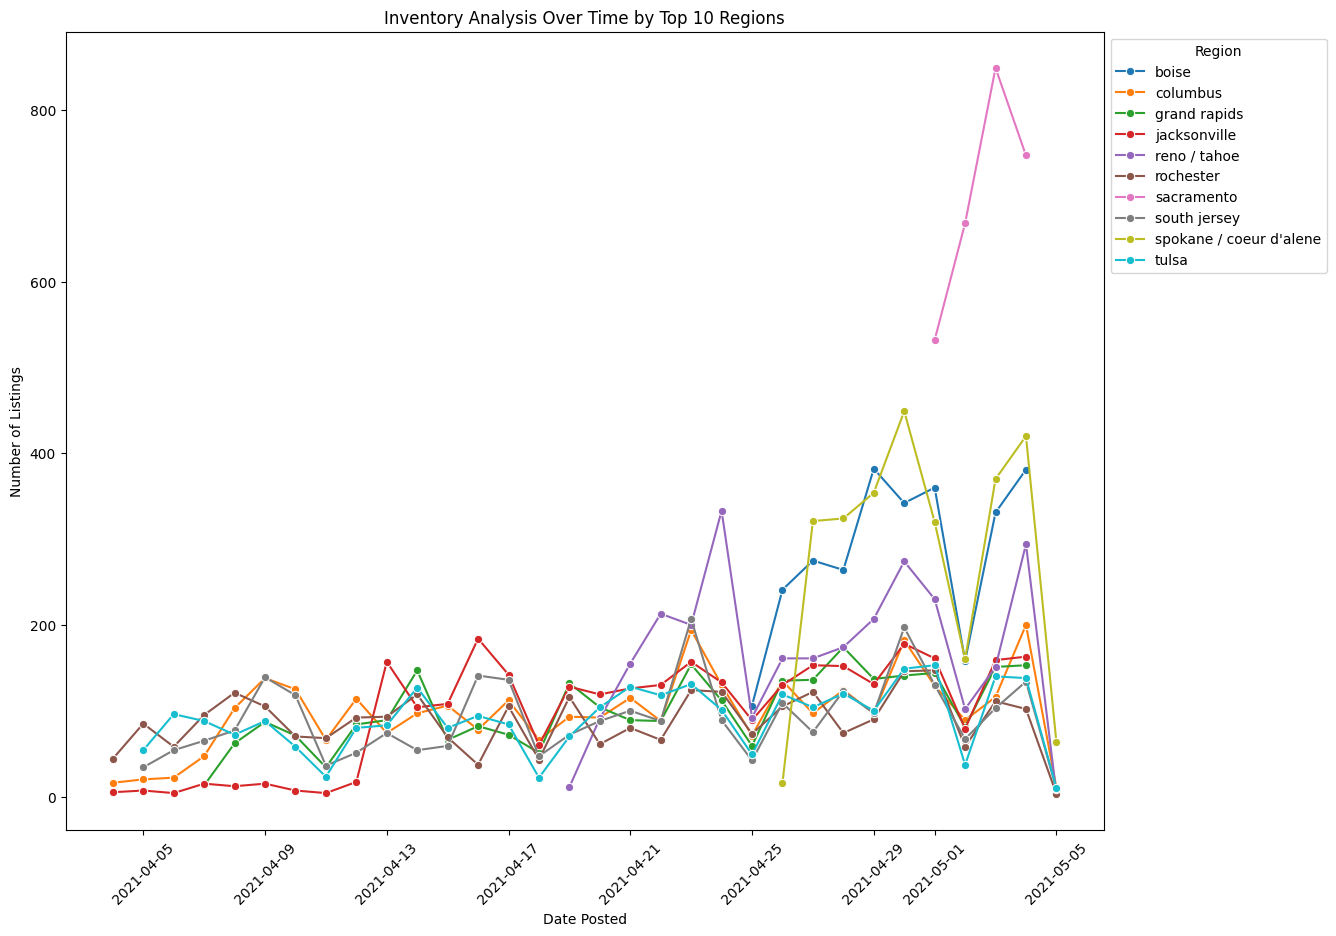

In [5]:
# Exploratory Data Analysis (EDA)

# Group the data by region and year
inventory_by_region_year = df.groupby(['region', 'posting_date']).size().reset_index(name='count')

# Identify the top 10 regions
top_regions = inventory_by_region_year.groupby('region')['count'].sum().nlargest(10).index

# Filter the dataset to include only the listings from the top 10 regions
top_regions_inventory = inventory_by_region_year[inventory_by_region_year['region'].isin(top_regions)]

# Plot the inventory over time for each of the top 10 regions
plt.figure(figsize=(14, 10))
sns.lineplot(data=top_regions_inventory, x='posting_date', y='count', hue='region', marker='o')
plt.title('Inventory Analysis Over Time by Top 10 Regions')
plt.xlabel('Date Posted')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=3.0)
plt.show()


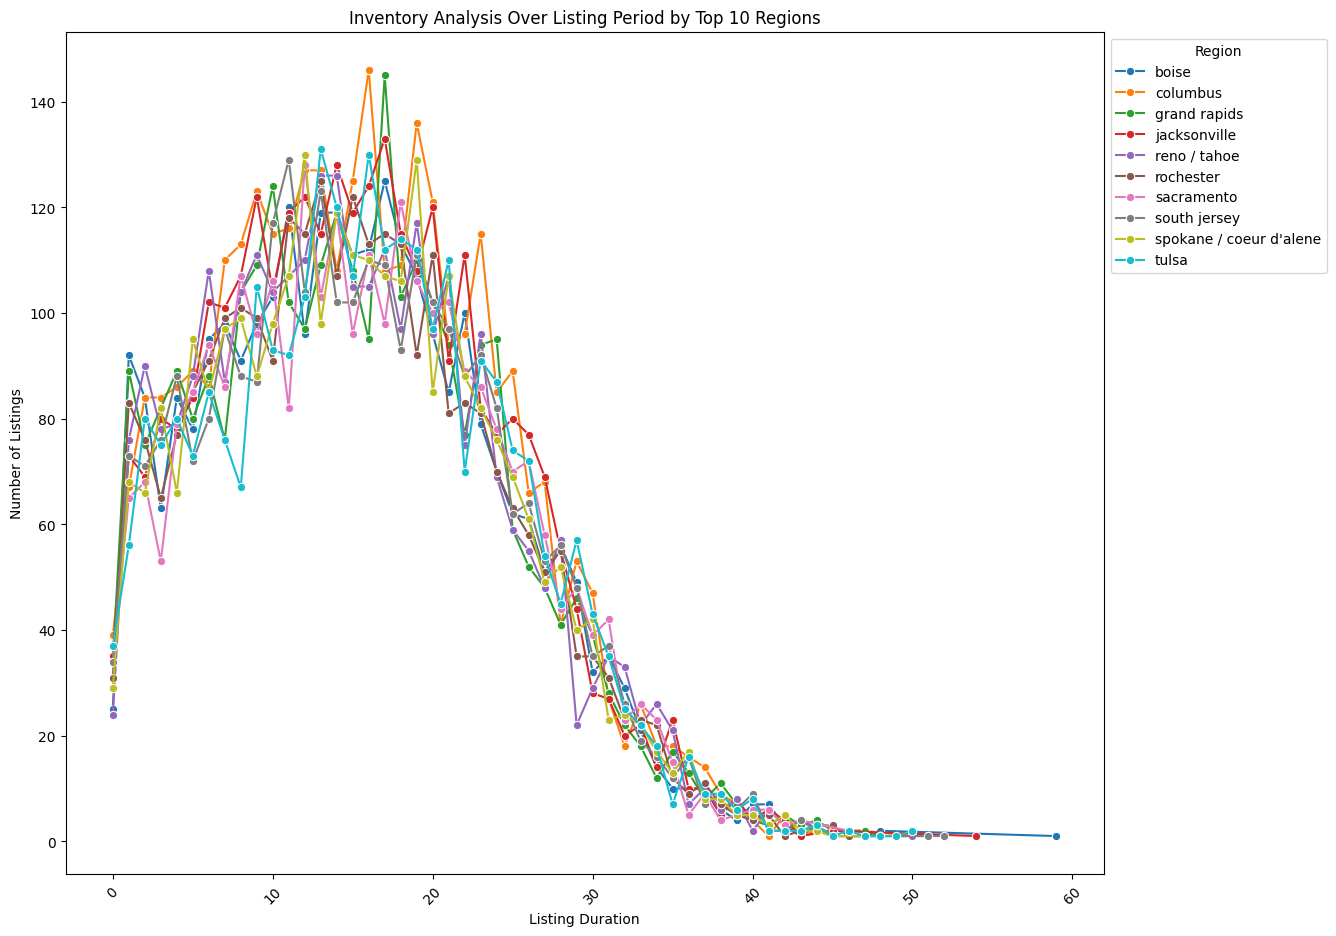

In [6]:
# Inventory Analysis Over Listing Period by Top 10 Regions

# Group the data by region and year
inventory_by_region_year = df.groupby(['region', 'listing_duration']).size().reset_index(name='count')

# Identify the top 10 regions
top_regions = inventory_by_region_year.groupby('region')['count'].sum().nlargest(10).index

# Filter the dataset to include only the listings from the top 10 regions
top_regions_inventory = inventory_by_region_year[inventory_by_region_year['region'].isin(top_regions)]

# Plot the inventory over time for each of the top 10 regions
plt.figure(figsize=(14, 10))
sns.lineplot(data=top_regions_inventory, x='listing_duration', y='count', hue='region', marker='o')
plt.title('Inventory Analysis Over Listing Period by Top 10 Regions')
plt.xlabel('Listing Duration')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=3.0)
plt.show()

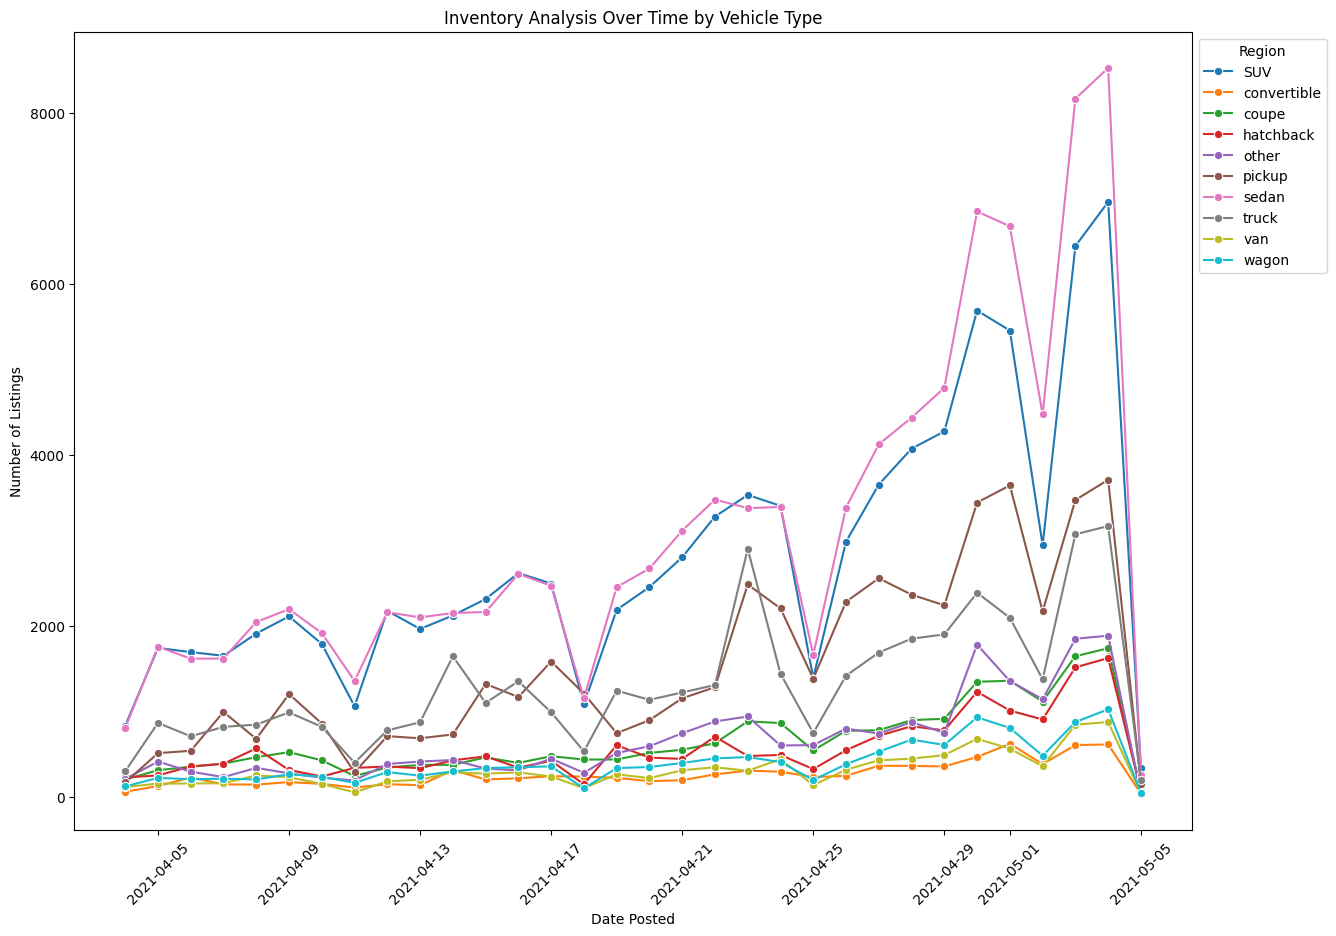

In [7]:
# Inventory Analysis Over Time by Vehicle Type

# Group the data by region and year
inventory_by_region_year = df.groupby(['type', 'posting_date']).size().reset_index(name='count')

# Identify the top 10 regions
top_regions = inventory_by_region_year.groupby('type')['count'].sum().nlargest(10).index

# Filter the dataset to include only the listings from the top 10 regions
top_regions_inventory = inventory_by_region_year[inventory_by_region_year['type'].isin(top_regions)]

# Plot the inventory over time for each of the top 10 regions
plt.figure(figsize=(14, 10))
sns.lineplot(data=top_regions_inventory, x='posting_date', y='count', hue='type', marker='o')
plt.title('Inventory Analysis Over Time by Vehicle Type')
plt.xlabel('Date Posted')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=3.0)
plt.show()


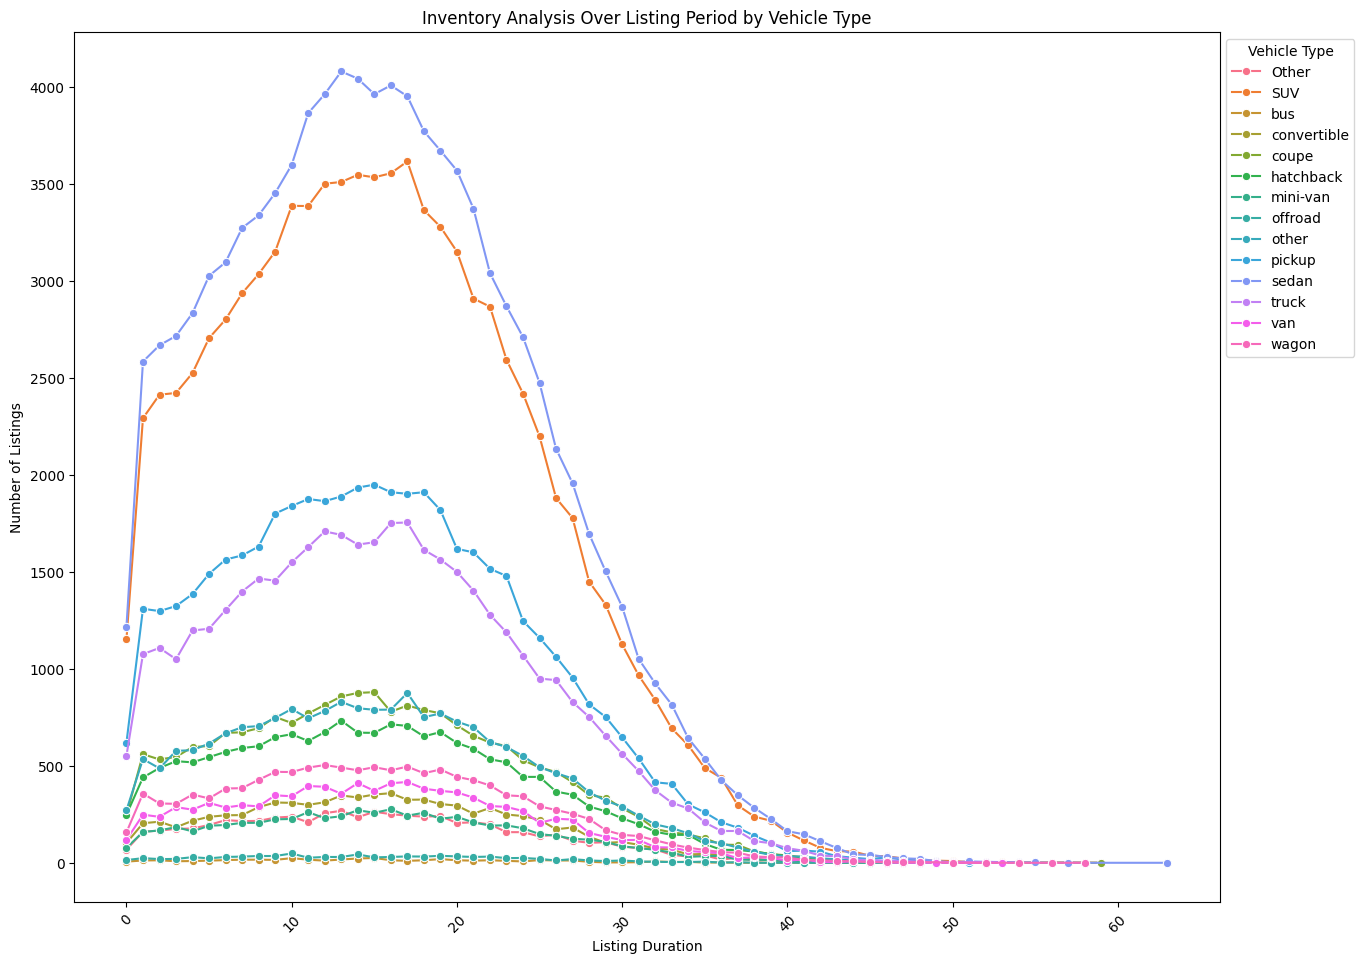

In [8]:
# Inventory Analysis Over Listing Period by Vehicle Type

# Group the data by type and posting date
inventory_by_type_year = df.groupby(['type', 'listing_duration']).size().reset_index(name='count')

# Plot the inventory over time for each type
plt.figure(figsize=(14, 10))
sns.lineplot(data=inventory_by_type_year, x='listing_duration', y='count', hue='type', marker='o')
plt.title('Inventory Analysis Over Listing Period by Vehicle Type')
plt.xlabel('Listing Duration')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.legend(title='Vehicle Type', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(pad=2.0) 
plt.show()


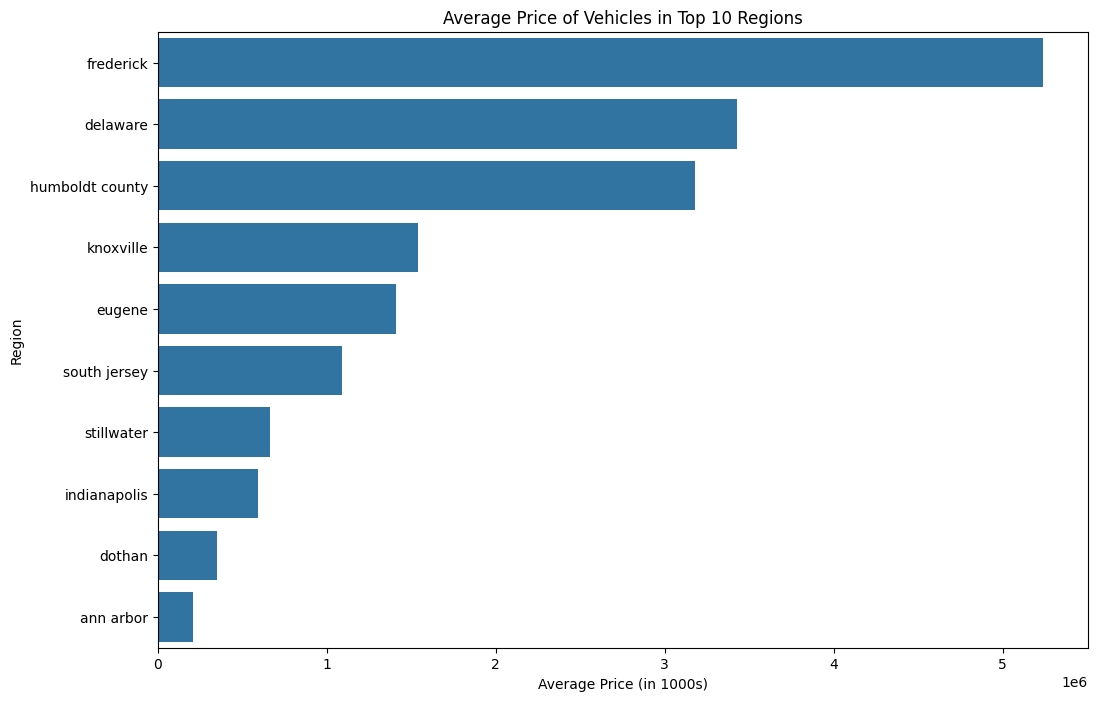

In [9]:
# Average Price of Vehicles in Top 10 Regions

# Group the data by region and calculate the average price for each region
average_price_by_region = df.groupby('region')['price'].mean().reset_index()

# Sort the regions based on average price
average_price_by_region = average_price_by_region.sort_values(by='price', ascending=False)

# Select the top 10 regions based on average price
top_10_regions = average_price_by_region.head(10)

# Create a visualization to compare the average prices of these top 10 regions
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_regions, x='price', y='region')
plt.title('Average Price of Vehicles in Top 10 Regions')
plt.xlabel('Average Price (in 1000s)')
plt.ylabel('Region')
plt.show()

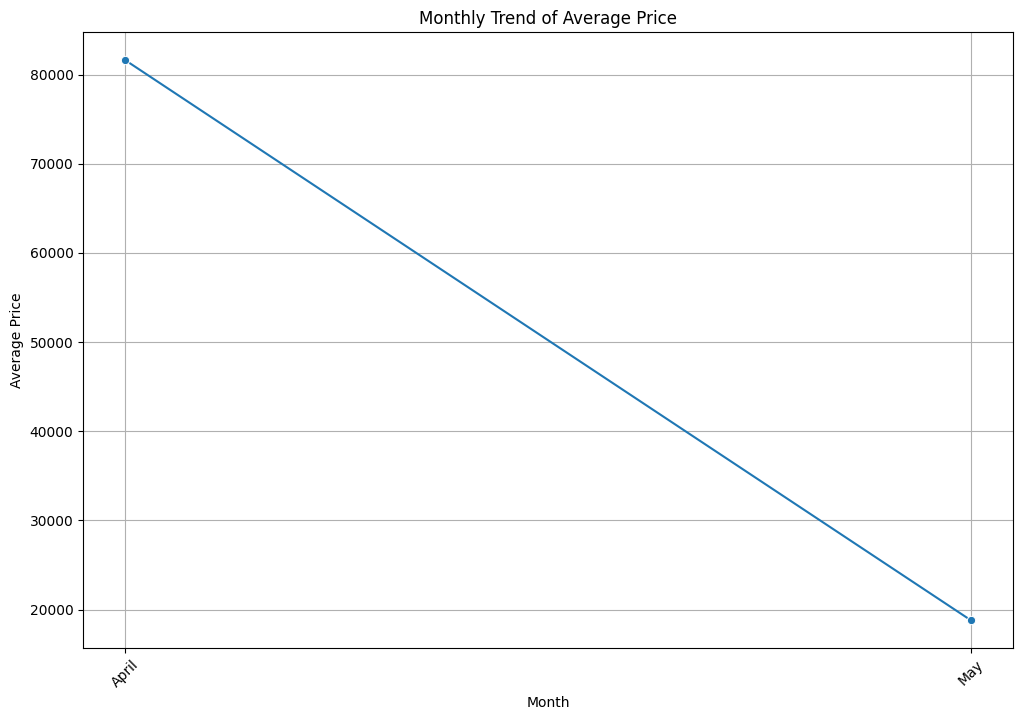

In [10]:
# Monthly Trend of Average Price

# Group the data by month and calculate the average price
average_price_by_month = df.groupby('posting_month')['price'].mean().reset_index()

# Sort the months
average_price_by_month['month'] = average_price_by_month['posting_month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%B'))

# Create a visualization to show the seasonal trend based on price
plt.figure(figsize=(12, 8))
sns.lineplot(data=average_price_by_month, x='month', y='price', marker='o')
plt.title('Monthly Trend of Average Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

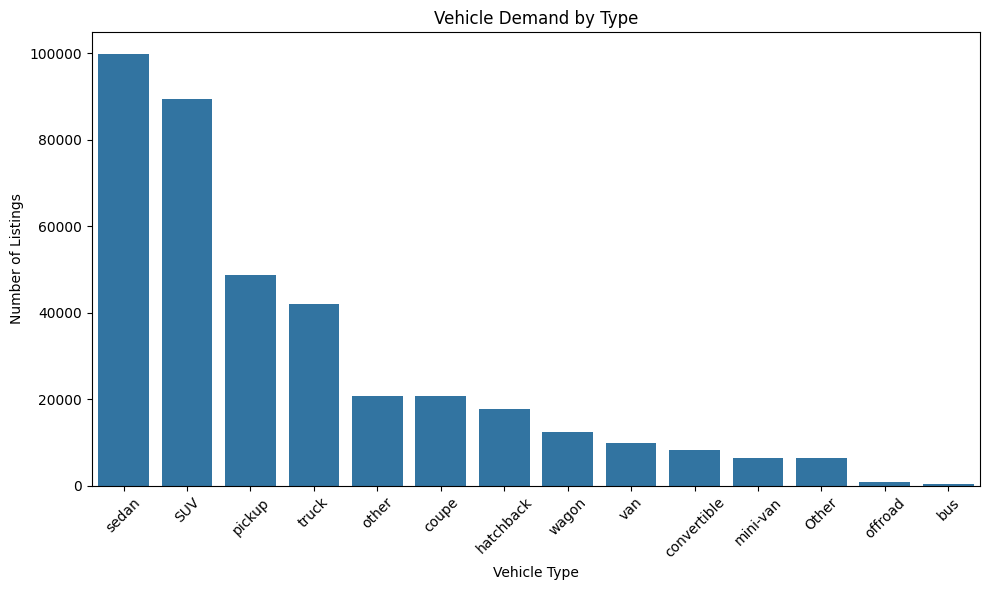

In [11]:
# Vehicle Demand by Type

# Group the data by the "type" column and count the number of listings for each type
demand_by_type = df['type'].value_counts().reset_index()
demand_by_type.columns = ['Type', 'Count']

# Create a visualization to display the demand for each vehicle type
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Count', data=demand_by_type)
plt.title('Vehicle Demand by Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

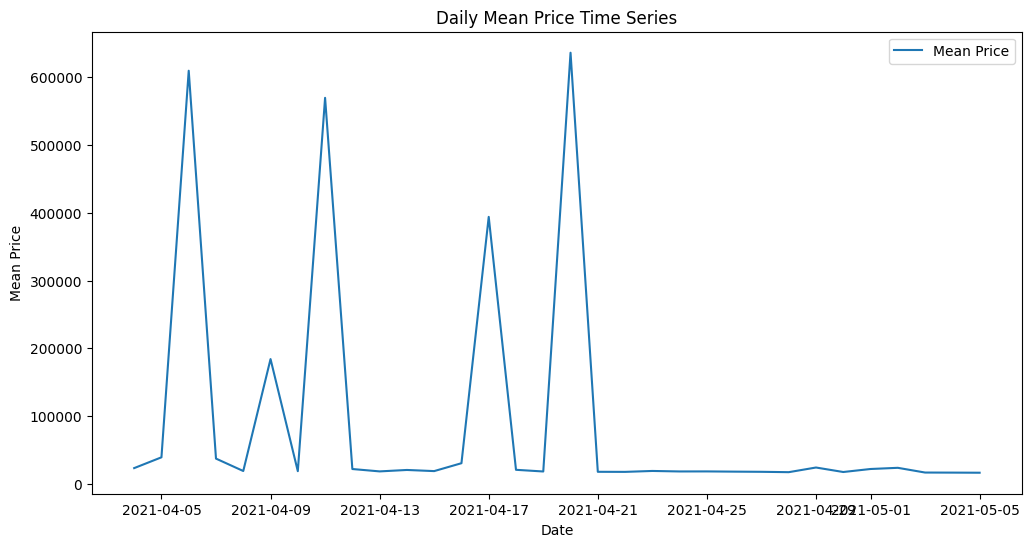

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   32
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -419.863
Date:                Thu, 14 Mar 2024   AIC                            851.726
Time:                        03:28:38   BIC                            860.330
Sample:                    04-04-2021   HQIC                           854.531
                         - 05-05-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0190      0.275     -3.710      0.000      -1.557      -0.481
ar.L2         -0.9836      0.308     -3.198      0.001      -1.586      -0.381
ar.L3         -0.7372      0.312     -2.362      0.0

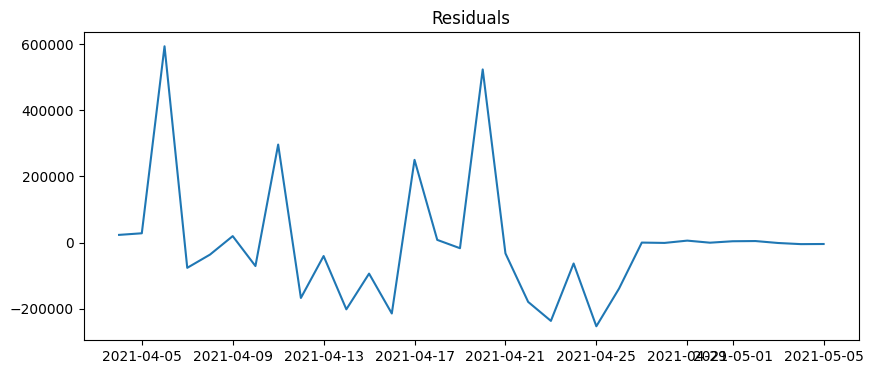

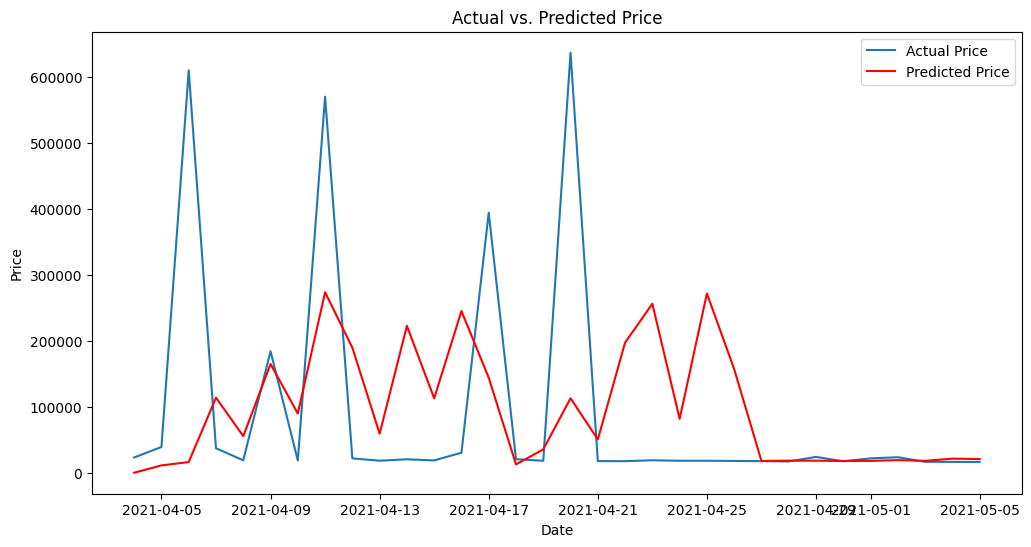

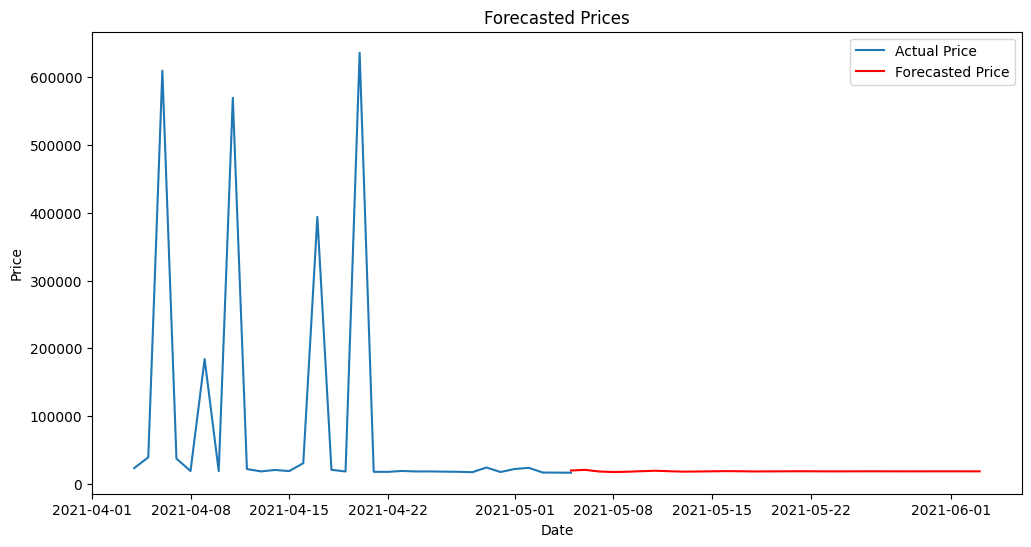

In [12]:
# Create an ARIMA time series model based on the posting_date and the mean price

# Convert 'posting_date' to datetime
df['posting_date'] = pd.to_datetime(df['posting_date'])

# Aggregate df by date and calculate mean price
daily_mean_price = df.groupby('posting_date')['price'].mean().reset_index()

# Set 'posting_date' as index
daily_mean_price.set_index('posting_date', inplace=True)

# Check for missing dates and fill them
min_date = daily_mean_price.index.min()
max_date = daily_mean_price.index.max()
all_dates = pd.date_range(start=min_date, end=max_date)
daily_mean_price = daily_mean_price.reindex(all_dates, fill_value=np.nan)

# Interpolate missing values
daily_mean_price['price'].interpolate(method='linear', inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(daily_mean_price.index, daily_mean_price['price'], label='Mean Price')
plt.title('Daily Mean Price Time Series')
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.legend()
plt.show()

# Fit ARIMA model
model = ARIMA(daily_mean_price['price'], order=(5,1,0))  
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(daily_mean_price.index, daily_mean_price['price'], label='Actual Price')
plt.plot(daily_mean_price.index, model_fit.fittedvalues, color='red', label='Predicted Price')
plt.title('Actual vs. Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Forecast future prices
forecast_steps = 30  # forecast next 30 days
forecast = model_fit.forecast(steps=forecast_steps)

# Plot forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(daily_mean_price.index, daily_mean_price['price'], label='Actual Price')
plt.plot(pd.date_range(start=max_date, periods=forecast_steps), forecast, color='red', label='Forecasted Price')
plt.title('Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
